# Load required libraries

In [2]:
import pandas as pd
import numpy as np
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# Download the datasets from private S3 bucket

In [25]:
!aws s3 cp 's3://ads508-team4-kuc/df_psych.csv' ./data/

download: s3://ads508-team4-kuc/df_psych.csv to data/df_psych.csv


In [26]:
import csv

df_psych = pd.read_csv(
    "./data/df_psych.csv",
    delimiter=",",
    quoting=csv.QUOTE_NONE,
)
df_psych = df_psych.iloc[:,1:]
df_psych.head(100)

,user_id,platform_x,level_1,level_2,level_3,confidence_score,country_code,asset_id,minutes_viewed,showtype,genre,running_minutes,source_language,season_id,series_id,studio_id,minutes_under_2
0,8.589935e+10,web-embed,Psychographics,Movies Lovers,Horror Movies Fans,0.07,ID,10377,1,Movies,Horror,87,Indonesian,NaN,NaN,350.0,True
1,8.589935e+10,web-embed,Psychographics,Movies Lovers,Indonesian Movies Fans,0.03,ID,10377,1,Movies,Horror,87,Indonesian,NaN,NaN,350.0,True
2,2.576980e+10,android,Psychographics,Movies Lovers,Romance Movies Fans,0.52,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
3,2.576980e+10,android,Psychographics,TV Lovers,Kids TV Fans,0.61,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
4,2.576980e+10,android,Psychographics,TV Lovers,Drama TV Fans,0.60,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,7.700000e+01,android,Psychographics,Movies Lovers,Korean Movies Fans,0.54,ID,10377,12,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
96,7.700000e+01,android,Psychographics,Movies Lovers,English Movies Fans,0.46,ID,10377,12,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
97,7.700000e+01,android,Psychographics,TV Lovers,English TV Fans,0.40,ID,10377,12,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
98,6.871948e+10,android,Psychographics,TV Lovers,English TV Fans,0.29,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False


# Clean up missing values and outliers

## Missing values first

Recall that we have some missing values in the dataset

In [27]:
df_psych.isnull().sum()

user_id                  0
platform_x               0
level_1                  0
level_2                  0
level_3               4850
confidence_score         0
country_code             0
asset_id                 0
minutes_viewed           0
showtype                 0
genre                    5
running_minutes          0
source_language        701
season_id           146311
series_id           146311
studio_id              300
minutes_under_2          0
dtype: int64

It occurs to us that some records don't have genres so we remove those specific records.

In [28]:
df_psych = df_psych.dropna(subset=['genre'])
df_psych.isnull().sum()
print('\n')

We are going to see which studios are missing the source language.

In [29]:
df1 = df_psych[['studio_id','source_language']]
df2 = df1.loc[df1['source_language'].isna()]
print(df2['studio_id'].unique())

[229. 321.  10. 301.  79. 442. 373.  73. 127. 390.  69. 226. 170. 111.
 241. 447.]


In [30]:
df1[df1['studio_id'].isin([229., 321.,  10., 301.,  79., 442., 373.,  73., 127., 390.,  69.,
       226., 170., 111., 241., 447.])].groupby('studio_id')['source_language'].nunique()

studio_id
10.0     2
69.0     1
73.0     0
79.0     0
111.0    0
127.0    1
170.0    1
226.0    2
229.0    1
241.0    0
301.0    0
321.0    0
373.0    0
390.0    1
442.0    0
447.0    1
Name: source_language, dtype: int64

For the studios that are missing source language, there can be no language, one language or two languages. To avoid confusion, we will remove records with missing studio_id and source_language.

In [31]:
df_psych = df_psych.dropna(subset=['studio_id','source_language'])
df_psych.isnull().sum()

user_id                  0
platform_x               0
level_1                  0
level_2                  0
level_3               4839
confidence_score         0
country_code             0
asset_id                 0
minutes_viewed           0
showtype                 0
genre                    0
running_minutes          0
source_language          0
season_id           145653
series_id           145653
studio_id                0
minutes_under_2          0
dtype: int64

We can see that season_id and series_id have euqal amount of records and recall the showtype in the dataset has only 2 types.

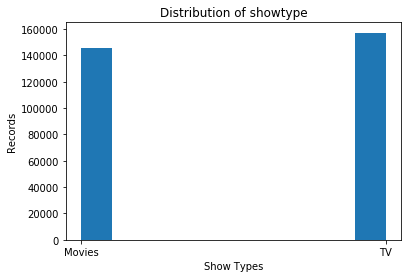

In [32]:
import matplotlib.pyplot as plt

plt.hist(df_psych['showtype'])
plt.xlabel("Show Types")
plt.ylabel("Records")
plt.title("Distribution of showtype")
plt.show()

In [33]:
df1 = df_psych[['showtype','season_id',"series_id"]]
df2 = df1.loc[(df1['season_id'].isna()) & (df1['series_id'].isna())]

In [34]:
df2.groupby('showtype')['season_id'].nunique()

showtype
Movies    1
Name: season_id, dtype: int64

In [35]:
df2.groupby('showtype')['series_id'].nunique()

showtype
Movies    1
Name: series_id, dtype: int64

This means that as long as we have valid season_id and series_id, the showtype must be TV shows while those values would be nulls for Movies.
Therefore, there is no need to keep season_id and series_id since they are directly correlated to showtype. So we remove the two columns.

In [36]:
df_psych = df_psych.drop(['season_id', 'series_id'], axis=1)
df_psych.isnull().sum()

user_id                0
platform_x             0
level_1                0
level_2                0
level_3             4839
confidence_score       0
country_code           0
asset_id               0
minutes_viewed         0
showtype               0
genre                  0
running_minutes        0
source_language        0
studio_id              0
minutes_under_2        0
dtype: int64

In [37]:
pd.unique(df_psych['level_3'])

array(['Horror Movies Fans', 'Indonesian Movies Fans',
       'Romance Movies Fans', 'Kids TV Fans', 'Drama TV Fans',
       'English TV Fans', 'Sports TV Fans', 'Malay TV Fans',
       'English Movies Fans', 'High Data Users',
       'Extreme Sports Movies Fans', 'Reality TV Fans', 'Comedy TV Fans',
       'Action and Adventure TV Fans', 'Comedy Movies Fans', nan,
       'Action and Adventure Movies Fans', 'Kids Movies Fans',
       'Local Commuters', 'Indonesian TV Fans', 'Thriller Movies Fans',
       'Korean TV Fans', 'Korean Movies Fans', 'Sci-Fi Movies Fans',
       'Drama Movies Fans', 'player', 'Malay Movies Fans',
       'Anime TV Fans', 'Fantasy Movies Fans', 'Family Movies Fans',
       '"""""""\\""""""""\\"""""""""""""""', 'Japanese TV Fans', 'casual',
       'Romance TV Fans', 'Japanese Movies Fans', 'Anime Movies Fans',
       'Chinese Movies Fans', 'Thai Movies Fans', 'Horror TV Fans',
       'Crime and Mystery Movies Fans', 'Hindi Movies Fans',
       'Turkish Movies Fa

Some level_3 traits are not valid, we will find out which level_2 traits those invalid level_3 traits belong to,
and replace the invalid level_3 traits to the same as level_2

In [39]:
pd.unique(df_psych['level_2'])

array(['Movies Lovers', 'TV Lovers', 'Mobile Enthusiasts',
       'News Junkies & Avid Readers', 'Travellers', 'Sports Fans',
       'iflix Viewing Behaviour', 'Social Media Fans', 'Music Lovers'],
      dtype=object)

In [40]:
lev3_null = df_psych.loc[df_psych['level_3'].isnull(), ('level_2')]
pd.unique(lev3_null)

array(['News Junkies & Avid Readers', 'Sports Fans', 'Music Lovers'],
      dtype=object)

In [41]:
# Replace level_3 traits for records having 
# level_2 traits as 'News Junkies & Avid Readers', 'Sports Fans', 'Music Lovers' with their own level_2 traits

df_psych['level_3'][df_psych.level_2 == 'News Junkies & Avid Readers'] = 'News Junkies & Avid Readers'
df_psych['level_3'][df_psych.level_2 == 'Sports Fans'] = 'Sports Fans'
df_psych['level_3'][df_psych.level_2 == 'Music Lovers'] = 'Music Lovers'

# hot-code level_3 trait for social media fans to social media fans
df_psych['level_3'][df_psych.level_2 == 'Social Media Fans'] = 'Social Media Fans'


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: Se

In [42]:
pd.unique(df_psych['level_3'])

array(['Horror Movies Fans', 'Indonesian Movies Fans',
       'Romance Movies Fans', 'Kids TV Fans', 'Drama TV Fans',
       'English TV Fans', 'Sports TV Fans', 'Malay TV Fans',
       'English Movies Fans', 'High Data Users',
       'Extreme Sports Movies Fans', 'Reality TV Fans', 'Comedy TV Fans',
       'Action and Adventure TV Fans', 'Comedy Movies Fans',
       'News Junkies & Avid Readers', 'Action and Adventure Movies Fans',
       'Kids Movies Fans', 'Local Commuters', 'Indonesian TV Fans',
       'Thriller Movies Fans', 'Korean TV Fans', 'Korean Movies Fans',
       'Sports Fans', 'Sci-Fi Movies Fans', 'Drama Movies Fans', 'player',
       'Malay Movies Fans', 'Anime TV Fans', 'Fantasy Movies Fans',
       'Family Movies Fans', 'Social Media Fans', 'Music Lovers',
       'Japanese TV Fans', 'casual', 'Romance TV Fans',
       'Japanese Movies Fans', 'Anime Movies Fans', 'Chinese Movies Fans',
       'Thai Movies Fans', 'Horror TV Fans',
       'Crime and Mystery Movies Fans',

## Now consider outliers..

Recall that we have plenty outilers in running_minutes and minutes_viewed

In [43]:
# Use a z-score of 3 as the cutoff

from scipy import stats


df_psych = df_psych[(np.abs(stats.zscore(df_psych['minutes_viewed']))< 3)]
df_psych = df_psych[(np.abs(stats.zscore(df_psych['running_minutes']))< 3)]

Text(0, 0.5, 'minutes_viewed')

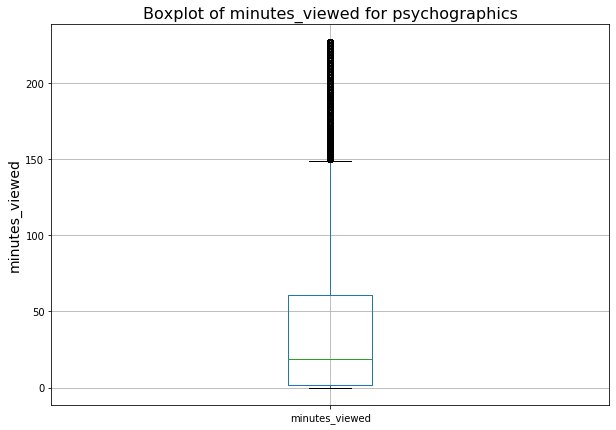

In [44]:
# Use boxplot to check for outliers in minutes_viewed

fig = plt.figure(figsize =(10, 7))
boxplot = df_psych.boxplot(column=['minutes_viewed'])
plt.title("Boxplot of minutes_viewed for psychographics", fontsize = 16)
plt.ylabel("minutes_viewed", fontsize= 14 )

Text(0, 0.5, 'running_minutes')

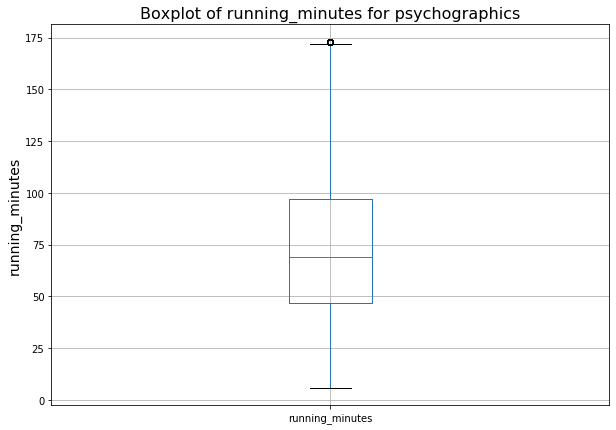

In [45]:
# Use boxplot to check for outliers in running_minutes

fig = plt.figure(figsize =(10, 7))
boxplot = df_psych.boxplot(column=['running_minutes'])
plt.title("Boxplot of running_minutes for psychographics", fontsize = 16)
plt.ylabel("running_minutes", fontsize= 14 )

# Feature Engineering

## Remove 'iflix Viewing Behaviour' from level_2 traits

In [46]:
df_psych[['level_2']].groupby('level_2').nunique()

,level_2
level_2,
Mobile Enthusiasts,1
Movies Lovers,1
Music Lovers,1
News Junkies & Avid Readers,1
Social Media Fans,1
Sports Fans,1
TV Lovers,1
Travellers,1
iflix Viewing Behaviour,1


Since "iflix Viewing Behaviour" doesn't fit into the rest of the traits, we will remove the records with it.

In [47]:
df_psych = df_psych[df_psych.level_2 != 'iflix Viewing Behaviour']
df_psych[['level_2']].groupby('level_2').nunique()

,level_2
level_2,
Mobile Enthusiasts,1
Movies Lovers,1
Music Lovers,1
News Junkies & Avid Readers,1
Social Media Fans,1
Sports Fans,1
TV Lovers,1
Travellers,1


## Simplify Certain Features

In [26]:
# viewing unique categories in these features - language, genre, and platform

pd.unique(df_psych['source_language'])

array(['Indonesian', 'English', 'Chinese', 'Malay', 'Nepali', 'Korean',
       'Tagalog', 'Japanese', 'Burmese', 'Kanuri', 'Thai', 'Hindi',
       'Tamil', 'Bengali', 'Vietnamese', 'Swahili', 'Central Khmer',
       'Portuguese', 'Urdu', 'Hungarian', 'Spanish; Castilian', 'French',
       'Italian', 'Turkish', 'Tajik', 'Swedish', 'Norwegian', 'Arabic',
       'Danish', 'Sinhala; Sinhalese', 'Afrikaans', 'Avaric'],
      dtype=object)

In [27]:
pd.unique(df_psych['genre'])

array(['Horror', 'Comedy', 'Drama', 'Thriller', 'Romance',
       'Action and Adventure', 'Others', 'Kids',
       'Documentary and Biography', 'Anime', 'Fantasy', 'Music',
       'Crime and Mystery', 'Sci-Fi', 'Reality', 'Sports',
       'Extreme Sports', 'Lifestyle and Fashion', 'Family', 'Game Show',
       'Best of Web or Viral', 'Animation', 'Education', 'eSports',
       'Adult Romance', 'News', 'Religion and Faith',
       'Health and Fitness', 'Live Events and Specials'], dtype=object)

In [28]:
pd.unique(df_psych['platform_x'])

array(['web-embed', 'android', 'iOS', 'android-tv', 'webOS', 'web',
       'Panasonic', 'web-pwa', 'Roku', 'Samsung Tizen', 'googlecast',
       'Vewd', 'Samsung Orsay'], dtype=object)

There's an opportunity to simplify the platform column

In [48]:
# Combine platforms into a more generalized group

def platform_type (row):
    if row['platform_x'] in ('android','iOS'):
        return 'mobile_phone'
    if row['platform_x'] in ('web-embed', 'webOS', 'web', 'web-pwa'):
        return 'web_based'
    if row['platform_x'] in ('android-tv', 'Panasonic', 'Roku', 'Samsung Tizen', 'googlecast', 'Vewd', 'Samsung Orsay'):
        return 'home_tv'
    return row['platform_x']

In [49]:
df_psych['platform_type'] = df_psych.apply(lambda row: platform_type(row), axis=1)

In [50]:
# creating a feature for if a program was watched for 2 (25th percentile) or more minutes

df_psych['viewed_2_plus'] = np.where(df_psych['minutes_viewed'] >= 2,1,0)

df_psych.head()

,user_id,platform_x,level_1,level_2,level_3,confidence_score,country_code,asset_id,minutes_viewed,showtype,genre,running_minutes,source_language,studio_id,minutes_under_2,platform_type,viewed_2_plus
0,8.589935e+10,web-embed,Psychographics,Movies Lovers,Horror Movies Fans,0.07,ID,10377,1,Movies,Horror,87,Indonesian,350.0,True,web_based,0
1,8.589935e+10,web-embed,Psychographics,Movies Lovers,Indonesian Movies Fans,0.03,ID,10377,1,Movies,Horror,87,Indonesian,350.0,True,web_based,0
2,2.576980e+10,android,Psychographics,Movies Lovers,Romance Movies Fans,0.52,ID,10377,3,Movies,Horror,87,Indonesian,350.0,False,mobile_phone,1
3,2.576980e+10,android,Psychographics,TV Lovers,Kids TV Fans,0.61,ID,10377,3,Movies,Horror,87,Indonesian,350.0,False,mobile_phone,1
4,2.576980e+10,android,Psychographics,TV Lovers,Drama TV Fans,0.60,ID,10377,3,Movies,Horror,87,Indonesian,350.0,False,mobile_phone,1


## Remove features that don't contribute to training models

In [51]:
df_psych = df_psych.drop(['user_id','level_1','level_3','asset_id','studio_id','minutes_under_2','platform_x'],axis = 1)
df_psych.head()

,level_2,confidence_score,country_code,minutes_viewed,showtype,genre,running_minutes,source_language,platform_type,viewed_2_plus
0,Movies Lovers,0.07,ID,1,Movies,Horror,87,Indonesian,web_based,0
1,Movies Lovers,0.03,ID,1,Movies,Horror,87,Indonesian,web_based,0
2,Movies Lovers,0.52,ID,3,Movies,Horror,87,Indonesian,mobile_phone,1
3,TV Lovers,0.61,ID,3,Movies,Horror,87,Indonesian,mobile_phone,1
4,TV Lovers,0.60,ID,3,Movies,Horror,87,Indonesian,mobile_phone,1


## Check Correlations between all independent variables

In [52]:
df = df_psych.drop(['level_2','confidence_score'],axis = 1)

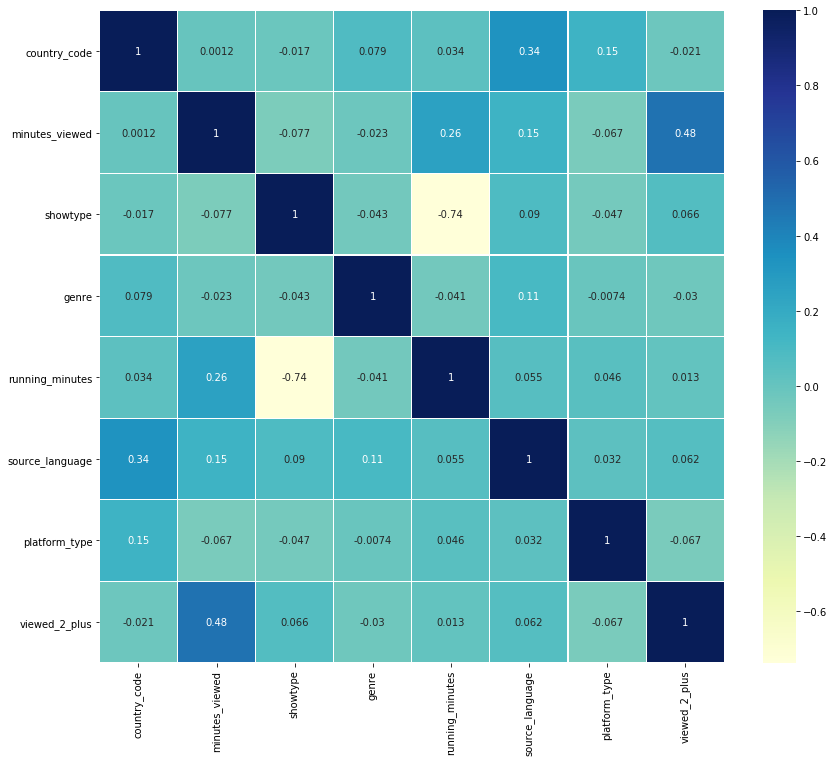

In [53]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])
    
    
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

Removing running_minutes from the dataframe due to high correlation with showtype, which we can recall from this:

In [54]:
sns.histplot(data=df_psych,x='running_minutes', hue = 'showtype', bins = 30)

AttributeError: module 'seaborn' has no attribute 'histplot'

running_minutes is almost directly related to the showtype.

In [55]:
df_psych = df_psych.drop(['running_minutes'],axis = 1)
df_psych.head()

,level_2,confidence_score,country_code,minutes_viewed,showtype,genre,source_language,platform_type,viewed_2_plus
0,Movies Lovers,0.07,ID,1,Movies,Horror,Indonesian,web_based,0
1,Movies Lovers,0.03,ID,1,Movies,Horror,Indonesian,web_based,0
2,Movies Lovers,0.52,ID,3,Movies,Horror,Indonesian,mobile_phone,1
3,TV Lovers,0.61,ID,3,Movies,Horror,Indonesian,mobile_phone,1
4,TV Lovers,0.60,ID,3,Movies,Horror,Indonesian,mobile_phone,1


Before balancing the data, we need to look at the confidence score from the original dataset:

In [56]:
df_psych['confidence_score'].describe()

count    279458.000000
mean          0.597657
std           0.311564
min           0.000000
25%           0.300000
50%           0.650000
75%           0.890000
max           1.000000
Name: confidence_score, dtype: float64

In [57]:
print('50th percentile: ', df_psych['confidence_score'].quantile(.5))
print('60th percentile: ', df_psych['confidence_score'].quantile(.6))
print('70th percentile: ', df_psych['confidence_score'].quantile(.7))
print('80th percentile: ', df_psych['confidence_score'].quantile(.8))
print('90th percentile: ', df_psych['confidence_score'].quantile(.9))
print('95th percentile: ', df_psych['confidence_score'].quantile(.95))

50th percentile:  0.65
60th percentile:  0.76
70th percentile:  0.86
80th percentile:  0.92
90th percentile:  0.98
95th percentile:  1.0


We want to ensure data quality and pick our record within 70th percentile

In [58]:
df_psych = df_psych.loc[df_psych['confidence_score'] > .86]
df_psych['confidence_score'].describe()

count    80385.000000
mean         0.949884
std          0.043058
min          0.870000
25%          0.910000
50%          0.960000
75%          0.990000
max          1.000000
Name: confidence_score, dtype: float64

Remove confidence_score from the dataset

In [59]:
df_psych = df_psych.drop(['confidence_score'], axis = 1)

# Balance The Data

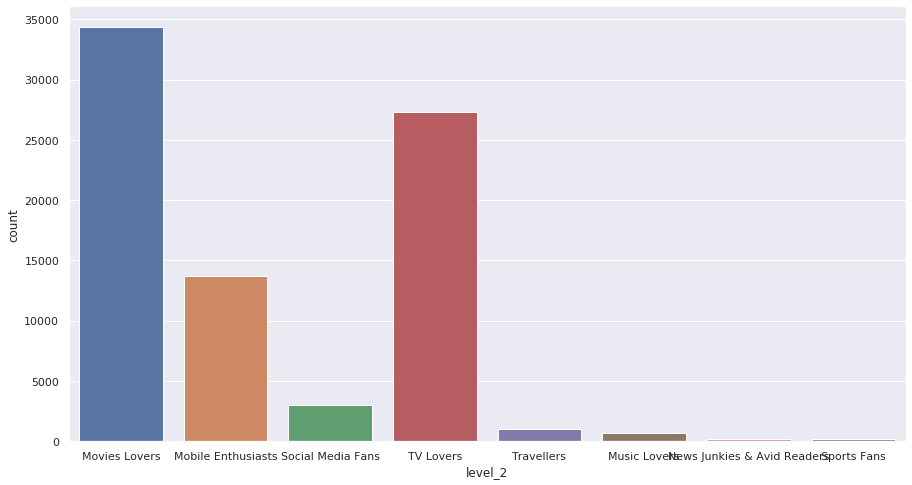

In [80]:
sns.set(rc={'figure.figsize':(15,8)})

sns.countplot(data=df_psych, x='level_2')

We can see that the target variable (level_2 trait) has a very uneven distribution the majority of its categories.

In [67]:
pd.set_option("display.max_rows", None)
df_psych['level_2'].value_counts()

Movies Lovers                  34345
TV Lovers                      27306
Mobile Enthusiasts             13712
Social Media Fans               3000
Travellers                       992
Music Lovers                     714
Sports Fans                      163
News Junkies & Avid Readers      153
Name: level_2, dtype: int64

In [68]:
# going to balance data set using oversampling to ensure we have data for 

df_grouped_by = df_psych.groupby(["level_2"])
df_balanced = df_grouped_by.apply(
lambda x: x.sample(df_grouped_by.size().max(),replace=True)\
.reset_index(drop=True)
)

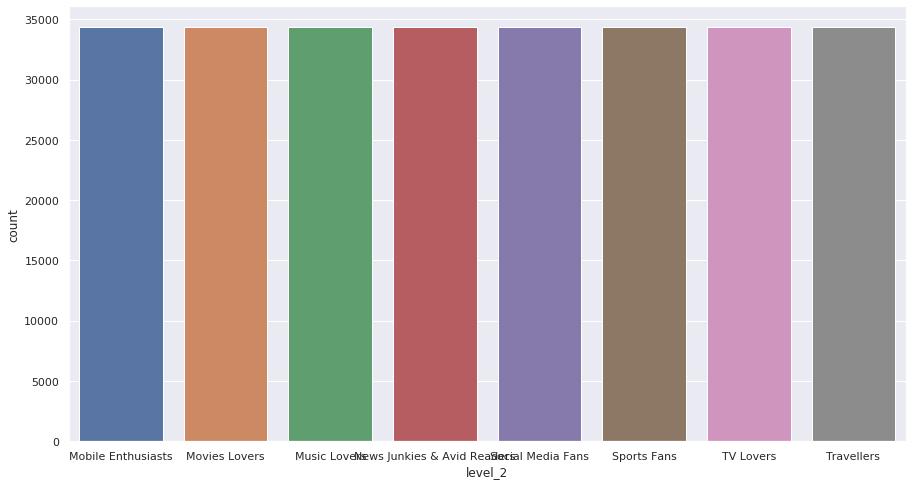

In [81]:
sns.set(rc={'figure.figsize':(15,8)})

sns.countplot(data=df_balanced, x='level_2')

In [71]:
df_balanced['level_2'].value_counts()

News Junkies & Avid Readers    34345
Mobile Enthusiasts             34345
Sports Fans                    34345
Music Lovers                   34345
TV Lovers                      34345
Travellers                     34345
Social Media Fans              34345
Movies Lovers                  34345
Name: level_2, dtype: int64

# Split the data into train, validate and test

In [72]:
# Split the data as: train - 90%, validate - 5%, test - 5%

from sklearn.model_selection import train_test_split

# Split all data into 70% train and 30% holdout
df_train, df_holdout = train_test_split(df_balanced, test_size=0.10, stratify=df_balanced['level_2'])

# Split holdout data into 50% validation and 50% test
df_validation, df_test = train_test_split(df_holdout, test_size=0.50, stratify=df_holdout['level_2'])

In [73]:
df_train.shape

(247284, 8)

In [83]:
df_train.head()

,,level_2,country_code,minutes_viewed,showtype,genre,source_language,platform_type,viewed_2_plus
level_2,,,,,,,,,
TV Lovers,25349,TV Lovers,ID,60,TV,Romance,Korean,mobile_phone,1
Music Lovers,30921,Music Lovers,ID,0,Movies,Horror,Indonesian,mobile_phone,0
Travellers,20480,Travellers,PH,121,Movies,Drama,Tagalog,mobile_phone,1
Social Media Fans,1460,Social Media Fans,ID,95,Movies,Comedy,Indonesian,mobile_phone,1
Movies Lovers,2152,Movies Lovers,MY,111,Movies,Action and Adventure,English,home_tv,1


In [84]:
df_validation.shape

df_validation.head()

level_2 country_code  minutes_viewed  \
level_2                                                                   
Movies Lovers     3123       Movies Lovers           MY              90   
Social Media Fans 22247  Social Media Fans           ID               8   
TV Lovers         16801          TV Lovers           MY              29   
                  10302          TV Lovers           ID              43   
Sports Fans       6051         Sports Fans           MY               0   

                        showtype                 genre source_language  \
level_2                                                                  
Movies Lovers     3123    Movies  Action and Adventure          French   
Social Media Fans 22247       TV                 Anime        Japanese   
TV Lovers         16801       TV                 Drama          Korean   
                  10302       TV                 Drama      Indonesian   
Sports Fans       6051        TV                  Kids         English   

                        platform_type  viewed_2_plus  
level_2                                               
Movies Lovers     3123   mobile_phone              1  
Social Media Fans 22247  mobile_phone              1  
TV Lovers         16801  mobile_phone              1  
                  10302  mobile_phone              1  
Sports Fans       6051   mobile_phone              0

In [75]:
df_test.shape

(13738, 8)

In [90]:
df_train = df_train.drop('level_2', axis=1)

df_train.head()

KeyError: "['level_2'] not found in axis"

In [93]:
df_train.index.value_counts

<bound method IndexOpsMixin.value_counts of MultiIndex([(                  'TV Lovers', 25349),
            (               'Music Lovers', 30921),
            (                 'Travellers', 20480),
            (          'Social Media Fans',  1460),
            (              'Movies Lovers',  2152),
            (         'Mobile Enthusiasts', 16337),
            ('News Junkies & Avid Readers', 27097),
            (                'Sports Fans', 33331),
            (          'Social Media Fans',  1974),
            ('News Junkies & Avid Readers', 18472),
            ...
            (                'Sports Fans',  6722),
            (         'Mobile Enthusiasts', 17192),
            (                  'TV Lovers', 23988),
            (                  'TV Lovers', 27830),
            (          'Social Media Fans', 20981),
            (                  'TV Lovers', 15910),
            (          'Social Media Fans',  6395),
            (                'Sports Fans',  4694),
    

# Save these files to S3 bucket

In [76]:
# Create a new s3 bucket
!aws s3 mb s3://ads508-team4-split

make_bucket: ads508-team4-split


In [86]:
# Store these 3 files

from io import StringIO

bucket = 'ads508-team4-split'
csv_buffer1 = StringIO()
csv_buffer2 = StringIO()
csv_buffer3 = StringIO()

df_train.to_csv(csv_buffer1)
df_validation.to_csv(csv_buffer2)
df_test.to_csv(csv_buffer3)

s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'df_train.csv').put(Body=csv_buffer1.getvalue())
s3_resource.Object(bucket, 'df_validation.csv').put(Body=csv_buffer2.getvalue())
s3_resource.Object(bucket, 'df_test.csv').put(Body=csv_buffer3.getvalue())

{'ResponseMetadata': {'RequestId': 'X1FBEKYY221AZ1WH',
  'HostId': 'jqzFd1VaNxGFybIyhRIEYmlhblnymsEoQKbNwKpUMBuHZMQKN4cDMNGE8cjgeU94ivLjTQxHkZE=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'jqzFd1VaNxGFybIyhRIEYmlhblnymsEoQKbNwKpUMBuHZMQKN4cDMNGE8cjgeU94ivLjTQxHkZE=',
   'x-amz-request-id': 'X1FBEKYY221AZ1WH',
   'date': 'Sun, 27 Mar 2022 23:26:53 GMT',
   'etag': '"fd27df061cacc9f09ca9944da938ad7d"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"fd27df061cacc9f09ca9944da938ad7d"'}

In [87]:
df_train.head()

,,country_code,minutes_viewed,showtype,genre,source_language,platform_type,viewed_2_plus
level_2,,,,,,,,
TV Lovers,25349,ID,60,TV,Romance,Korean,mobile_phone,1
Music Lovers,30921,ID,0,Movies,Horror,Indonesian,mobile_phone,0
Travellers,20480,PH,121,Movies,Drama,Tagalog,mobile_phone,1
Social Media Fans,1460,ID,95,Movies,Comedy,Indonesian,mobile_phone,1
Movies Lovers,2152,MY,111,Movies,Action and Adventure,English,home_tv,1
